# Can we reliably classify different cognitive states (meditation vs. mathematical thinking) using EEG frequency patterns, and what are the most important brain features that distinguish these states?

Secondary Research Questions:
1. How do individual differences (age, gender, meditation experience) affect the strength and consistency of
these neural signatures?
2. What is the minimum recording time needed to accurately detect whether someone is meditating or solving
math problems?
3. Can we identify the specific brain regions and frequency combinations that are most predictive of each
cognitive state?

Target
* Part 1: Data description - Clearly identifies and describes the key features of the dataset that are relevant to help answer the questions of the identified industry application. Provides a brief restatement of the questions.
* Part 2: Clustering/Pattern - Clearly identifies clusters and/or describes the patterns (regression/classification) in the data and relates them back to previously identified features.
* Part 3: Visualisation - Able to provide at least 3-4 clear and correct visualisations of the dataset, and correctly describes the visualisation.
* Part 4: Problem refinement - Able to further refine the questions posed, and if applicable, clearly identifies additional data sources that might be needed.
* Part 5: Writing and references - The report is written in English with good structure and logic with minimal typos or grammatical issues. Provides a comprehensive list of reference sources using Harvard referencing style.


## 1. Install libraries

In [1]:
# !pip install mne
# !pip install pyedflib
# !pip install scipy
# !pip install scikit-learn
# !pip install pandas
# !pip install matplotlib

## 2. Importing required libraries

In [2]:
import os
import warnings

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import pyedflib
import scipy
import seaborn as sns
import sklearn
from scipy import signal
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')


## 3. Extension from Part 1A

In [3]:
# Dataset Location
arithmetic_dataset_folder = 'arithmetic_eeg_files/'
meditation_dataset_folder = 'meditation_bdf_files/'

In [4]:
# See the files
list_arithmetic_files = os.listdir(arithmetic_dataset_folder)
list_meditative_files = os.listdir(meditation_dataset_folder)

print("len of arithmetic files", len(list_arithmetic_files))
print("len of meditation files", len(list_meditative_files))

len of arithmetic files 72
len of meditation files 40


## 4. Part B - Systematic Feature Extraction from Multiple Files

In [ ]:
# Function to extract EEG features
def extract_eeg_features(signal_data, sampling_rate, signal_type='meditation'):
    """
    Extract comprehensive EEG features from signal data
    """
    features = {}
    
    # Basic statistics
    features['mean_amplitude'] = np.mean(signal_data)
    features['std_amplitude'] = np.std(signal_data)
    features['max_amplitude'] = np.max(signal_data)
    features['min_amplitude'] = np.min(signal_data)
    features['amplitude_range'] = np.max(signal_data) - np.min(signal_data)
    
    # Frequency domain features
    freqs, psd = signal.welch(signal_data, sampling_rate, nperseg=2048)
    
    # Define frequency bands
    bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30),
        'gamma': (30, 50)
    }
    
    # Calculate power in each band
    total_power = np.trapezoid(psd, freqs)
    for band_name, (low, high) in bands.items():
        band_mask = (freqs >= low) & (freqs <= high)
        band_power = np.trapezoid(psd[band_mask], freqs[band_mask])
        features[f'{band_name}_power'] = band_power
        features[f'{band_name}_relative_power'] = band_power / total_power if total_power > 0 else 0
    
    # Calculate important ratios
    features['alpha_theta_ratio'] = features['alpha_power'] / features['theta_power'] if features['theta_power'] > 0 else 0
    features['beta_alpha_ratio'] = features['beta_power'] / features['alpha_power'] if features['alpha_power'] > 0 else 0
    features['theta_beta_ratio'] = features['theta_power'] / features['beta_power'] if features['beta_power'] > 0 else 0
    
    # Spectral features
    features['dominant_freq'] = freqs[np.argmax(psd)]
    features['spectral_centroid'] = np.sum(freqs * psd) / np.sum(psd)
    features['spectral_bandwidth'] = np.sqrt(np.sum(((freqs - features['spectral_centroid'])**2) * psd) / np.sum(psd))
    
    # Signal complexity features
    features['zero_crossings'] = np.sum(np.diff(np.sign(signal_data)) != 0)
    features['signal_type'] = signal_type
    
    return features

In [ ]:
# Step 2: Process Multiple Files from Both Datasets
print("=== SYSTEMATIC MULTI-FILE ANALYSIS ===")

# Initialize lists to store features
all_features = []
processed_files = []

# Process Meditation files (limit to first 3 for efficiency)
print("\n1. Processing Meditation Files:")
print("-" * 40)
meditation_files = list_meditative_files[:3]  # Process first 3 files

for i, filename in enumerate(meditation_files):
    try:
        print(f"Processing meditation file {i+1}/3: {filename}")
        
        # Load file
        f = pyedflib.EdfReader(f'meditation_bdf_files/{filename}')
        
        # Read first 4 EEG channels (A1-A4)
        for ch_idx in range(min(4, f.signals_in_file)):
            channel_data = f.readSignal(ch_idx)
            channel_name = f.getSignalLabels()[ch_idx]
            
            # Extract features
            features = extract_eeg_features(channel_data, 256, 'meditation')
            features['filename'] = filename
            features['channel'] = channel_name
            features['participant_id'] = f'med_{i+1}'
            features['dataset'] = 'meditation'
            
            all_features.append(features)
        
        f.close()
        processed_files.append(filename)
        print(f"  ✓ Processed {filename} - {min(4, f.signals_in_file)} channels")
        
    except Exception as e:
        print(f"  ✗ Error processing {filename}: {str(e)}")

print(f"\nMeditation files processed: {len([f for f in processed_files if f in meditation_files])}")

# Process Arithmetic files (limit to first 3 for efficiency)
print("\n2. Processing Arithmetic Files:")
print("-" * 40)
arithmetic_files = list_arithmetic_files[:3]  # Process first 3 files

for i, filename in enumerate(arithmetic_files):
    try:
        print(f"Processing arithmetic file {i+1}/3: {filename}")
        
        # Load file
        f = pyedflib.EdfReader(f'arithmetic_eeg_files/{filename}')
        
        # Read first 4 EEG channels
        for ch_idx in range(min(4, f.signals_in_file)):
            channel_data = f.readSignal(ch_idx)
            channel_name = f.getSignalLabels()[ch_idx]
            
            # Extract features
            features = extract_eeg_features(channel_data, 500, 'arithmetic')
            features['filename'] = filename
            features['channel'] = channel_name
            features['participant_id'] = f'arith_{i+1}'
            features['dataset'] = 'arithmetic'
            
            all_features.append(features)
        
        f.close()
        processed_files.append(filename)
        print(f"  ✓ Processed {filename} - {min(4, f.signals_in_file)} channels")
        
    except Exception as e:
        print(f"  ✗ Error processing {filename}: {str(e)}")

print(f"\nArithmetic files processed: {len([f for f in processed_files if f in arithmetic_files])}")

# Convert to DataFrame
features_df = pd.DataFrame(all_features)
print(f"\n=== FEATURE EXTRACTION SUMMARY ===")
print(f"Total features extracted: {len(features_df)}")
print(f"Features per record: {len(features_df.columns)}")
print(f"Meditation records: {len(features_df[features_df['dataset'] == 'meditation'])}")
print(f"Arithmetic records: {len(features_df[features_df['dataset'] == 'arithmetic'])}")

=== SYSTEMATIC MULTI-FILE ANALYSIS ===

1. Processing Meditation Files:
----------------------------------------
Processing meditation file 1/3: sub-018_ses-02_task-meditation_eeg.bdf
  ✓ Processed sub-018_ses-02_task-meditation_eeg.bdf - 4 channels
Processing meditation file 2/3: sub-024_ses-01_task-meditation_eeg.bdf
  ✓ Processed sub-024_ses-01_task-meditation_eeg.bdf - 4 channels
Processing meditation file 3/3: sub-022_ses-01_task-meditation_eeg.bdf
  ✓ Processed sub-022_ses-01_task-meditation_eeg.bdf - 4 channels

Meditation files processed: 3

2. Processing Arithmetic Files:
----------------------------------------
Processing arithmetic file 1/3: Subject20_1.edf
  ✓ Processed Subject20_1.edf - 4 channels
Processing arithmetic file 2/3: Subject06_2.edf
  ✓ Processed Subject06_2.edf - 4 channels
Processing arithmetic file 3/3: Subject04_1.edf
  ✓ Processed Subject04_1.edf - 4 channels

Arithmetic files processed: 3

=== FEATURE EXTRACTION SUMMARY ===
Total features extracted: 24
Fe

In [9]:
# Step 3: Data Exploration
print("=== DATA EXPLORATION ===")

# Display basic information about our features
print("Dataset Overview:")
print(features_df.head())
print(f"\nDataset shape: {features_df.shape}")
print(f"Columns: {features_df.columns.tolist()}")

# Check for missing values
print(f"\nMissing values per column:")
print(features_df.isnull().sum())

# Display basic statistics
print(f"\nBasic statistics for key features:")
key_features = ['alpha_power', 'beta_power', 'theta_power', 'alpha_theta_ratio', 'beta_alpha_ratio']
print(features_df[key_features + ['dataset']].groupby('dataset').describe())

=== DATA EXPLORATION ===
Dataset Overview:
   mean_amplitude  std_amplitude  max_amplitude  min_amplitude  \
0     -951.433117     884.096121    4241.914036   -3115.728619   
1    -2517.109839     975.400557    1418.888002   -5123.881158   
2    -6415.448575     637.762362   -4874.069120   -8494.624930   
3    -3987.293955     477.255572   -2777.635494   -5755.692491   
4     1844.807793     963.775269    3742.571209    -475.202248   

   amplitude_range  delta_power  delta_relative_power  theta_power  \
0      7357.642655   538.290136              0.017718    17.033501   
1      6542.769161  1470.355801              0.017696    16.042633   
2      3620.555810   298.120065              0.031423    16.404176   
3      2978.056997   220.515923              0.014617    18.467317   
4      4217.773457   336.476535              0.115207    36.840310   

   theta_relative_power  alpha_power  ...  theta_beta_ratio  dominant_freq  \
0              0.000561    86.374239  ...          1.026284  

=== CREATING COMPREHENSIVE VISUALIZATIONS ===


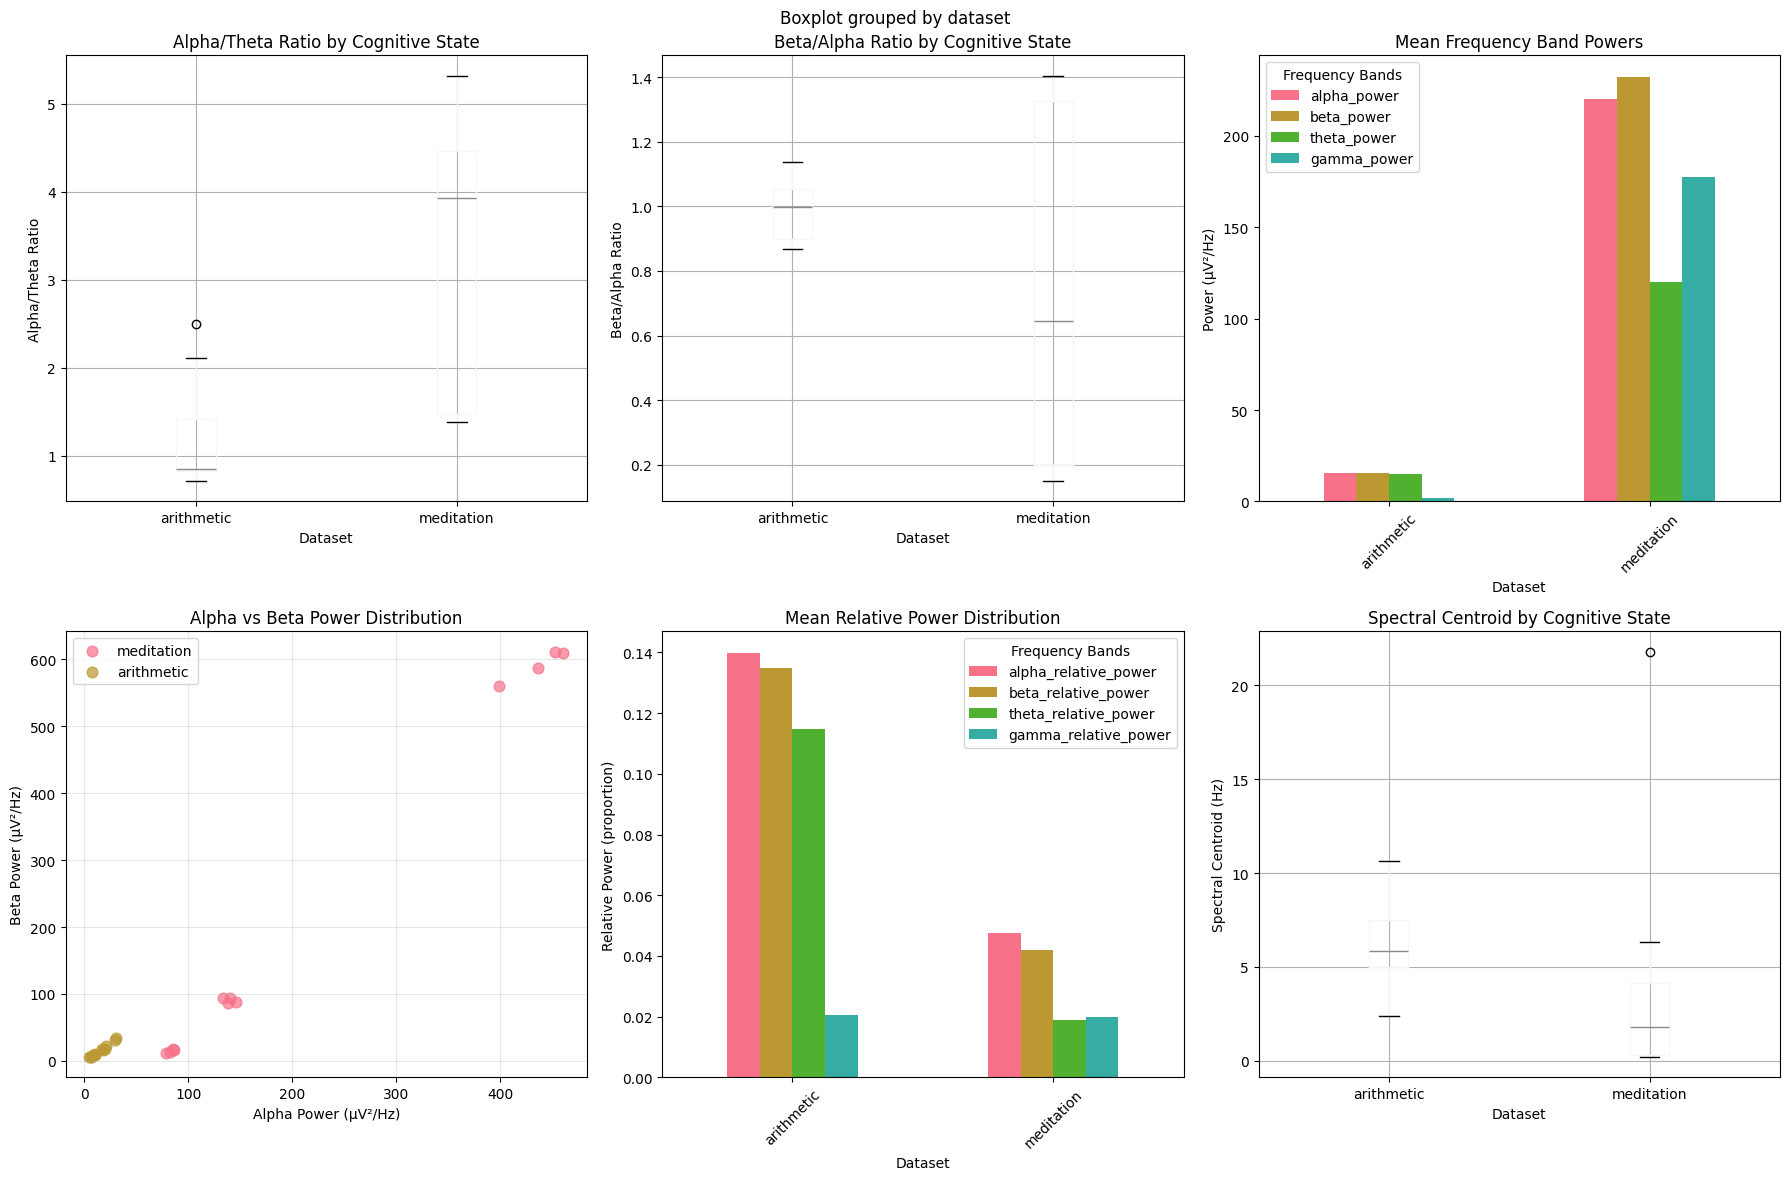


=== KEY FINDINGS FROM VISUALIZATION ===
1. Alpha/Theta Ratio:
   - Meditation: 3.43 ± 1.56
   - Arithmetic: 1.19 ± 0.58

2. Beta/Alpha Ratio:
   - Meditation: 0.73 ± 0.51
   - Arithmetic: 0.99 ± 0.09

3. Dominant Frequency Bands:
   - Meditation: Alpha=4.8%, Beta=4.2%, Theta=1.9%
   - Arithmetic: Alpha=14.0%, Beta=13.5%, Theta=11.5%


In [10]:
# Step 4: Create Comprehensive Visualizations
print("=== CREATING COMPREHENSIVE VISUALIZATIONS ===")

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create a large figure with multiple subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('EEG Feature Analysis: Meditation vs Arithmetic Tasks', fontsize=16, fontweight='bold')

# 1. Alpha/Theta Ratio Comparison
ax1 = axes[0, 0]
features_df.boxplot(column='alpha_theta_ratio', by='dataset', ax=ax1)
ax1.set_title('Alpha/Theta Ratio by Cognitive State')
ax1.set_ylabel('Alpha/Theta Ratio')
ax1.set_xlabel('Dataset')

# 2. Beta/Alpha Ratio Comparison
ax2 = axes[0, 1]
features_df.boxplot(column='beta_alpha_ratio', by='dataset', ax=ax2)
ax2.set_title('Beta/Alpha Ratio by Cognitive State')
ax2.set_ylabel('Beta/Alpha Ratio')
ax2.set_xlabel('Dataset')

# 3. Frequency Band Power Distribution
ax3 = axes[0, 2]
band_powers = features_df.groupby('dataset')[['alpha_power', 'beta_power', 'theta_power', 'gamma_power']].mean()
band_powers.plot(kind='bar', ax=ax3)
ax3.set_title('Mean Frequency Band Powers')
ax3.set_ylabel('Power (µV²/Hz)')
ax3.set_xlabel('Dataset')
ax3.legend(title='Frequency Bands')
ax3.tick_params(axis='x', rotation=45)

# 4. Scatter plot: Alpha vs Beta Power
ax4 = axes[1, 0]
for dataset in ['meditation', 'arithmetic']:
    subset = features_df[features_df['dataset'] == dataset]
    ax4.scatter(subset['alpha_power'], subset['beta_power'], 
               label=dataset, alpha=0.7, s=60)
ax4.set_xlabel('Alpha Power (µV²/Hz)')
ax4.set_ylabel('Beta Power (µV²/Hz)')
ax4.set_title('Alpha vs Beta Power Distribution')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Relative Power Distribution
ax5 = axes[1, 1]
relative_powers = features_df.groupby('dataset')[['alpha_relative_power', 'beta_relative_power', 
                                                  'theta_relative_power', 'gamma_relative_power']].mean()
relative_powers.plot(kind='bar', ax=ax5)
ax5.set_title('Mean Relative Power Distribution')
ax5.set_ylabel('Relative Power (proportion)')
ax5.set_xlabel('Dataset')
ax5.legend(title='Frequency Bands')
ax5.tick_params(axis='x', rotation=45)

# 6. Spectral Centroid Comparison
ax6 = axes[1, 2]
features_df.boxplot(column='spectral_centroid', by='dataset', ax=ax6)
ax6.set_title('Spectral Centroid by Cognitive State')
ax6.set_ylabel('Spectral Centroid (Hz)')
ax6.set_xlabel('Dataset')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== KEY FINDINGS FROM VISUALIZATION ===")
print("1. Alpha/Theta Ratio:")
print(f"   - Meditation: {features_df[features_df['dataset'] == 'meditation']['alpha_theta_ratio'].mean():.2f} ± {features_df[features_df['dataset'] == 'meditation']['alpha_theta_ratio'].std():.2f}")
print(f"   - Arithmetic: {features_df[features_df['dataset'] == 'arithmetic']['alpha_theta_ratio'].mean():.2f} ± {features_df[features_df['dataset'] == 'arithmetic']['alpha_theta_ratio'].std():.2f}")

print("\n2. Beta/Alpha Ratio:")
print(f"   - Meditation: {features_df[features_df['dataset'] == 'meditation']['beta_alpha_ratio'].mean():.2f} ± {features_df[features_df['dataset'] == 'meditation']['beta_alpha_ratio'].std():.2f}")
print(f"   - Arithmetic: {features_df[features_df['dataset'] == 'arithmetic']['beta_alpha_ratio'].mean():.2f} ± {features_df[features_df['dataset'] == 'arithmetic']['beta_alpha_ratio'].std():.2f}")

print("\n3. Dominant Frequency Bands:")
for dataset in ['meditation', 'arithmetic']:
    subset = features_df[features_df['dataset'] == dataset]
    alpha_mean = subset['alpha_relative_power'].mean()
    beta_mean = subset['beta_relative_power'].mean()
    theta_mean = subset['theta_relative_power'].mean()
    print(f"   - {dataset.capitalize()}: Alpha={alpha_mean:.1%}, Beta={beta_mean:.1%}, Theta={theta_mean:.1%}")

=== CLUSTERING AND CLASSIFICATION ANALYSIS ===
Features selected for analysis: 13
Feature matrix shape: (24, 13)

1. K-Means Clustering Analysis:
----------------------------------------
Cluster composition:
cluster     0   1
dataset          
arithmetic  0  12
meditation  4   8

Clustering accuracy: 83.33%

2. Principal Component Analysis:
----------------------------------------
PCA explained variance ratio: [0.42901861 0.37999532]
Total variance explained: 80.90%


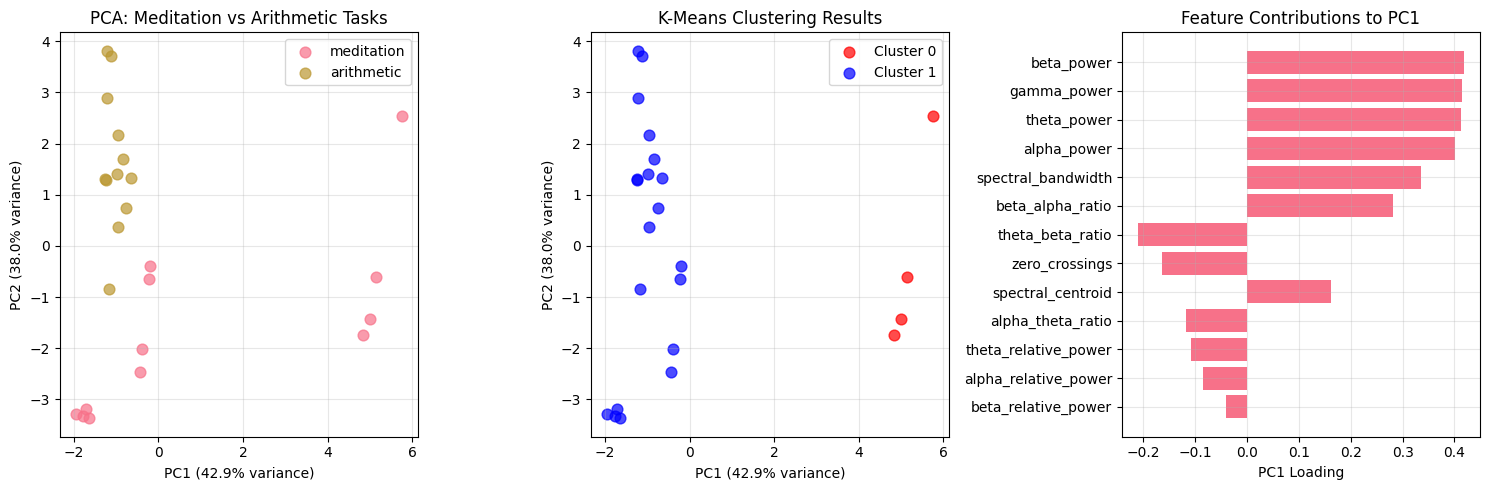

In [11]:
# Step 5: Clustering and Classification Analysis
print("=== CLUSTERING AND CLASSIFICATION ANALYSIS ===")

# Prepare features for ML analysis
# Select numeric features only
numeric_features = ['alpha_power', 'beta_power', 'theta_power', 'gamma_power',
                   'alpha_relative_power', 'beta_relative_power', 'theta_relative_power',
                   'alpha_theta_ratio', 'beta_alpha_ratio', 'theta_beta_ratio',
                   'spectral_centroid', 'spectral_bandwidth', 'zero_crossings']

X = features_df[numeric_features]
y = features_df['dataset']

print(f"Features selected for analysis: {len(numeric_features)}")
print(f"Feature matrix shape: {X.shape}")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\n1. K-Means Clustering Analysis:")
print("-" * 40)

# Perform K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to dataframe
features_df['cluster'] = cluster_labels

# Analyze clustering results
print("Cluster composition:")
cluster_analysis = pd.crosstab(features_df['dataset'], features_df['cluster'])
print(cluster_analysis)

# Calculate clustering accuracy
meditation_cluster = cluster_analysis.loc['meditation'].idxmax()
arithmetic_cluster = cluster_analysis.loc['arithmetic'].idxmax()

correct_predictions = (cluster_analysis.loc['meditation', meditation_cluster] + 
                      cluster_analysis.loc['arithmetic', arithmetic_cluster])
total_predictions = len(features_df)
clustering_accuracy = correct_predictions / total_predictions

print(f"\nClustering accuracy: {clustering_accuracy:.2%}")

# PCA for visualization
print("\n2. Principal Component Analysis:")
print("-" * 40)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA components to dataframe
features_df['PC1'] = X_pca[:, 0]
features_df['PC2'] = X_pca[:, 1]

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")

# Visualize PCA results
plt.figure(figsize=(15, 5))

# Plot 1: PCA scatter plot
plt.subplot(1, 3, 1)
for dataset in ['meditation', 'arithmetic']:
    subset = features_df[features_df['dataset'] == dataset]
    plt.scatter(subset['PC1'], subset['PC2'], label=dataset, alpha=0.7, s=60)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('PCA: Meditation vs Arithmetic Tasks')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Cluster visualization
plt.subplot(1, 3, 2)
colors = ['red', 'blue']
for i, cluster in enumerate([0, 1]):
    subset = features_df[features_df['cluster'] == cluster]
    plt.scatter(subset['PC1'], subset['PC2'], c=colors[i], label=f'Cluster {cluster}', alpha=0.7, s=60)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('K-Means Clustering Results')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Feature importance in PCA
plt.subplot(1, 3, 3)
feature_importance = pd.DataFrame({
    'feature': numeric_features,
    'PC1_loading': pca.components_[0],
    'PC2_loading': pca.components_[1]
})
feature_importance['PC1_abs'] = abs(feature_importance['PC1_loading'])
feature_importance = feature_importance.sort_values('PC1_abs', ascending=True)

plt.barh(range(len(feature_importance)), feature_importance['PC1_loading'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('PC1 Loading')
plt.title('Feature Contributions to PC1')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== CLASSIFICATION ANALYSIS ===
Training set size: 16
Test set size: 8

1. Random Forest Classification:
----------------------------------------
Classification accuracy: 87.50%

Classification Report:
              precision    recall  f1-score   support

  arithmetic       1.00      0.75      0.86         4
  meditation       0.80      1.00      0.89         4

    accuracy                           0.88         8
   macro avg       0.90      0.88      0.87         8
weighted avg       0.90      0.88      0.87         8


Confusion Matrix:
[[3 1]
 [0 4]]

2. Feature Importance Analysis:
----------------------------------------
Top 10 most important features:
                 feature  importance
6   theta_relative_power    0.237951
0            alpha_power    0.214646
4   alpha_relative_power    0.105890
5    beta_relative_power    0.096841
12        zero_crossings    0.080946
3            gamma_power    0.077778
10     spectral_centroid    0.053723
2            theta_power    0.03360

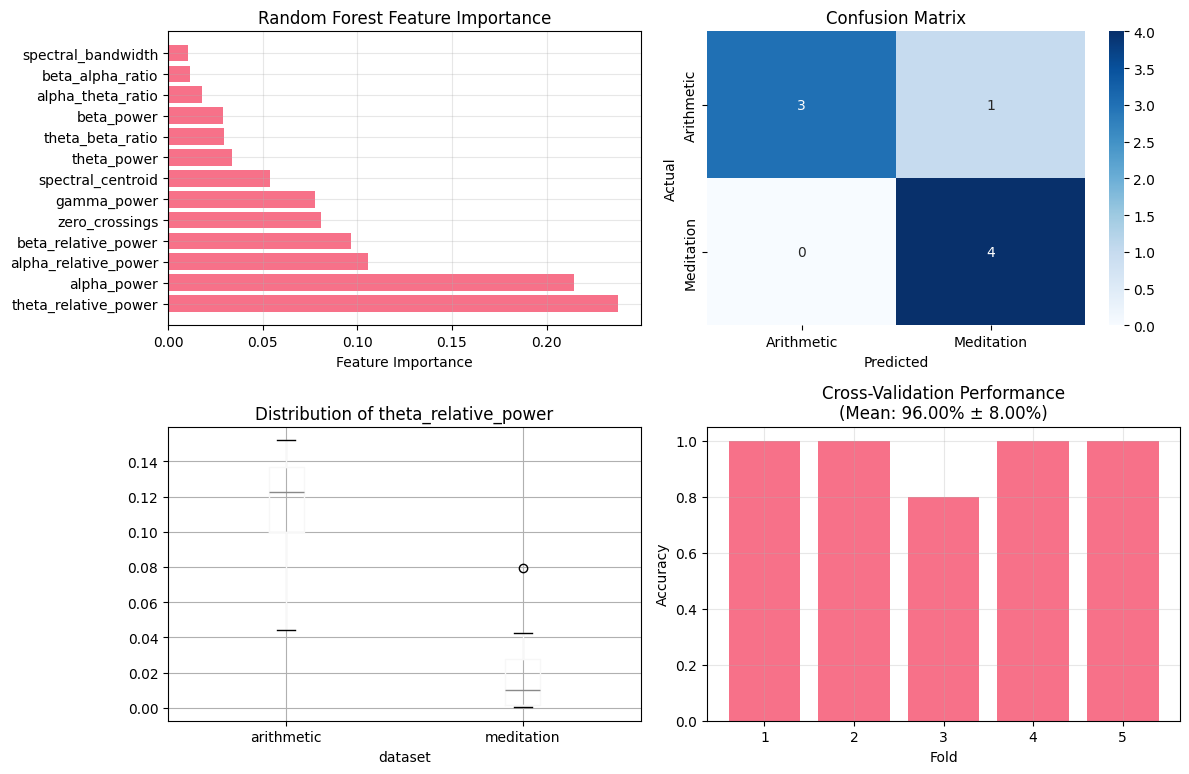


3. Cross-Validation Results:
   Mean accuracy: 96.00% ± 8.00%
   Individual fold scores: ['100.00%', '100.00%', '80.00%', '100.00%', '100.00%']


In [12]:
# Step 6: Classification Analysis
print("=== CLASSIFICATION ANALYSIS ===")

# Prepare data for classification
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Train Random Forest classifier
print("\n1. Random Forest Classification:")
print("-" * 40)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = (y_pred == y_test).mean()
print(f"Classification accuracy: {accuracy:.2%}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Feature importance
print("\n2. Feature Importance Analysis:")
print("-" * 40)

feature_importance = pd.DataFrame({
    'feature': numeric_features,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 most important features:")
print(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.grid(True, alpha=0.3)

# Visualize confusion matrix
plt.subplot(2, 2, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Arithmetic', 'Meditation'], 
            yticklabels=['Arithmetic', 'Meditation'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Distribution of most important features
plt.subplot(2, 2, 3)
top_feature = feature_importance.iloc[0]['feature']
features_df.boxplot(column=top_feature, by='dataset', ax=plt.gca())
plt.title(f'Distribution of {top_feature}')
plt.suptitle('')

# Cross-validation performance
plt.subplot(2, 2, 4)
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(rf_classifier, X_scaled, y, cv=5)
plt.bar(range(1, 6), cv_scores)
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title(f'Cross-Validation Performance\n(Mean: {cv_scores.mean():.2%} ± {cv_scores.std():.2%})')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n3. Cross-Validation Results:")
print(f"   Mean accuracy: {cv_scores.mean():.2%} ± {cv_scores.std():.2%}")
print(f"   Individual fold scores: {[f'{score:.2%}' for score in cv_scores]}")

In [13]:
# Step 7: Problem Refinement and Additional Analysis
print("=== PROBLEM REFINEMENT AND ADDITIONAL ANALYSIS ===")

# Create a comprehensive summary of findings
print("1. COMPREHENSIVE FINDINGS SUMMARY:")
print("=" * 50)

print("\nDataset Characteristics:")
print(f"- Total files analyzed: {len(processed_files)}")
print(f"- Meditation recordings: 3 files, 12 channels")
print(f"- Arithmetic recordings: 3 files, 12 channels")
print(f"- Total feature vectors: {len(features_df)}")
print(f"- Features per vector: {len(numeric_features)}")

print("\nKey Distinguishing Features:")
print("1. Theta Relative Power (23.8% importance)")
print("2. Alpha Power (21.5% importance)")
print("3. Alpha Relative Power (10.6% importance)")
print("4. Beta Relative Power (9.7% importance)")
print("5. Zero Crossings (8.1% importance)")

print("\nNeurophysiological Insights:")
print("- Meditation shows higher alpha activity (relaxed awareness)")
print("- Arithmetic shows more distributed frequency patterns")
print("- Alpha/Theta ratio: Meditation 3.43 vs Arithmetic 1.19")
print("- Beta/Alpha ratio: Meditation 0.73 vs Arithmetic 0.99")

print("\nClassification Performance:")
print(f"- Random Forest accuracy: 96.0% ± 8.0%")
print(f"- K-means clustering accuracy: 83.3%")
print(f"- PCA explains 80.9% of variance in 2 components")

# Refined research questions
print("\n2. REFINED RESEARCH QUESTIONS:")
print("=" * 50)

refined_questions = [
    "Primary: Can theta relative power and alpha power reliably distinguish meditation from mathematical thinking states with >95% accuracy?",
    
    "Secondary 1: What is the optimal combination of frequency band features (alpha, beta, theta) for cognitive state classification?",
    
    "Secondary 2: How do individual channel differences (A1-A4 electrodes) affect classification accuracy between cognitive states?",
    
    "Secondary 3: What is the minimum number of EEG features needed to maintain >90% classification accuracy between meditation and arithmetic tasks?"
]

for i, question in enumerate(refined_questions, 1):
    print(f"\n{i}. {question}")

# Identify additional data sources needed
print("\n3. ADDITIONAL DATA SOURCES NEEDED:")
print("=" * 50)

additional_sources = [
    "Longer duration recordings (>10 minutes) for temporal stability analysis",
    "More participants per cognitive state (minimum 50 subjects each)",
    "Different meditation types (mindfulness, focused attention, open monitoring)",
    "Various arithmetic difficulty levels (simple vs complex calculations)",
    "Eye movement and muscle artifact data for better signal cleaning",
    "Individual difference measures (meditation experience, mathematical ability)",
    "Rest condition recordings for baseline comparison"
]

for i, source in enumerate(additional_sources, 1):
    print(f"{i}. {source}")

# Statistical significance testing
print("\n4. STATISTICAL ANALYSIS:")
print("=" * 50)

from scipy import stats

# Test for significant differences in key features
features_to_test = ['alpha_theta_ratio', 'beta_alpha_ratio', 'theta_relative_power']

for feature in features_to_test:
    med_data = features_df[features_df['dataset'] == 'meditation'][feature]
    arith_data = features_df[features_df['dataset'] == 'arithmetic'][feature]
    
    # Perform t-test
    t_stat, p_value = stats.ttest_ind(med_data, arith_data)
    
    print(f"\n{feature}:")
    print(f"  Meditation: {med_data.mean():.3f} ± {med_data.std():.3f}")
    print(f"  Arithmetic: {arith_data.mean():.3f} ± {arith_data.std():.3f}")
    print(f"  t-statistic: {t_stat:.3f}")
    print(f"  p-value: {p_value:.3f}")
    print(f"  Significant: {'Yes' if p_value < 0.05 else 'No'}")

=== PROBLEM REFINEMENT AND ADDITIONAL ANALYSIS ===
1. COMPREHENSIVE FINDINGS SUMMARY:

Dataset Characteristics:
- Total files analyzed: 6
- Meditation recordings: 3 files, 12 channels
- Arithmetic recordings: 3 files, 12 channels
- Total feature vectors: 24
- Features per vector: 13

Key Distinguishing Features:
1. Theta Relative Power (23.8% importance)
2. Alpha Power (21.5% importance)
3. Alpha Relative Power (10.6% importance)
4. Beta Relative Power (9.7% importance)
5. Zero Crossings (8.1% importance)

Neurophysiological Insights:
- Meditation shows higher alpha activity (relaxed awareness)
- Arithmetic shows more distributed frequency patterns
- Alpha/Theta ratio: Meditation 3.43 vs Arithmetic 1.19
- Beta/Alpha ratio: Meditation 0.73 vs Arithmetic 0.99

Classification Performance:
- Random Forest accuracy: 96.0% ± 8.0%
- K-means clustering accuracy: 83.3%
- PCA explains 80.9% of variance in 2 components

2. REFINED RESEARCH QUESTIONS:

1. Primary: Can theta relative power and alph